## _*Simulating Quantum Cosmology on Quantum Computers*_

This notebook demonstrates how to use the `QISKit ACQUA` library to invoke the VQE algorithm and process the result.

Further information is available for the algorithms in the QISKit ACQUA github repo qiskit_acqua/readme.md.

For the inputs used to make the results on the poster, look at the individual settings files in the Github repository.

In [1]:
from qiskit_acqua import Operator, run_algorithm
from qiskit_acqua.input import get_input_instance
import matplotlib.pyplot as plt
from ckalgomethods import get_algorithm_ck
import numpy as np
from qiskit_acqua.utils.variational_forms.ryspecialdw import VarFormRYSpecialDW
from qiskit_acqua.utils.variational_forms.ryspecial import VarFormRYSpecial
from qiskit_acqua.utils.variational_forms.ryspecialqho import VarFormRYSpecialQHO
from qiskit_acqua.utils.variational_forms.ryspecialfull import VarFormRYSpecialFull
from qiskit_acqua.utils.variational_forms.ryspecialfull2 import VarFormRYSpecialFull2
from qiskit_acqua.utils.variational_forms.ryspecialfull3 import VarFormRYSpecialFull3
from qiskit import QuantumCircuit, ClassicalRegister, execute
from Jupyter_Code import circuitImage
from qiskit import available_backends, register, get_backend
%matplotlib notebook
# NOTE: if you want to edit or add a circuit, you will need to restart the kernel before running again so QISKit can re-register
# it.

In [2]:
##### INPUTS #####
# Other options are given in the comments afterward, roughly in an order corresponding to ones that match up well together.
ham_name = 'anharmonic_osc.txt' #'doubled_harmonic_fixed.txt' #'doubled_double_well_fixed.txt'  #'doubled_anharmonic_fixed.txt' #'anharmonic_osc.txt' # 'double_well.txt' # 'qho_3qubits_test.txt'
circuit_name = 'RYSpecial' # RYSpecialFull # RYSpecialFull3 # RYSpecialFull2  # RYSpecial  # RYSpecialDW # RYSpecialQHO # 'RY' # 'RYRZ'
depth = 1 # 3 seems ok, although can be decreased with more shots. Some circuits have hard-coded depth.
shots = 8192 # 8192 seems to have the best balance of accuracy and time-taken.
optimizer_name = 'SPSA' # only use SPSA, others do not work as well
backend_name = 'local_qasm_simulator' 
max_trials = 70 # Judge this based on convergence plot. 

Here an Operator instance is created for our Hamiltonian. 

In [3]:
# this is the actual loading
qubitOp = Operator.load_from_file(ham_name)
# To display Hamiltonian, use this:
# qubitOp.matrix

We can now use the Operator without regard to how it was created. First we need to prepare the configuration params to invoke the algorithm. Here we will use the ExactEigensolver first to return the smallest eigenvalue. Backend is not required since this is computed classically not using quantum computation. We then add in the qubitOp Operator in dictionary format. Now the complete params can be passed to the algorithm and run. The result is a dictionary.

In [4]:
# Find the exact energy
algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'algorithm': algorithm_cfg
}
algo_input = get_input_instance('EnergyInput')
algo_input.qubit_op = qubitOp
result_exact = run_algorithm(params,algo_input)
exact_energy = result_exact['energies'][0]
print(result_exact)

{'eigvals': array([0.54311567-4.71351011e-17j]), 'eigvecs': array([[-2.21638262e-01-9.73627891e-01j,  3.76418316e-16+4.96088820e-16j,
         1.18608299e-02+5.21030742e-02j,  1.27465317e-15+3.31742200e-16j,
         1.69057481e-03+7.42647397e-03j, -4.52010653e-16-1.80873528e-16j,
        -7.54398656e-04-3.31397461e-03j,  2.06978484e-16+1.34601893e-16j,
         1.05963135e-04+4.65482192e-04j, -1.57701845e-17+8.44916162e-17j,
         1.81472165e-05+7.97183483e-05j, -8.23801778e-17+3.26195805e-17j,
        -1.48823480e-05-6.53762078e-05j, -7.84616804e-17-3.03531118e-18j,
         4.37540406e-06+1.92205776e-05j,  5.22743868e-16+7.90685482e-17j]]), 'energy': 0.543115668497824, 'wavefunction': array([[-2.21638262e-01-9.73627891e-01j,  3.76418316e-16+4.96088820e-16j,
         1.18608299e-02+5.21030742e-02j,  1.27465317e-15+3.31742200e-16j,
         1.69057481e-03+7.42647397e-03j, -4.52010653e-16-1.80873528e-16j,
        -7.54398656e-04-3.31397461e-03j,  2.06978484e-16+1.34601893e-16j,
    

Now we want the VQE answer, so change it and add its other configuration parameters. VQE also needs and optimizer and variational form. While we can omit them from the dictionary, such that defaults are used, here we specify them explicitly so we can set their parameters as we desire.

In [5]:
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}
    
if optimizer_name == 'SPSA':
    optimizer_cfg = {
        'name': 'SPSA', 
        'max_trials': max_trials,
        'save_steps': 1
    }    

var_form_cfg = {
    'name': circuit_name,
    'depth': depth,
    'entanglement': 'linear'
}

backend_cfg = {
    'name': backend_name, 
    'shots': shots
}

params = {
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': backend_cfg
}

(VERY ROUGHLY) SPSA QASM predicted time to completion: 2.0 min
Exact = 0.543115668497824
VQE = 0.3814981234556303
Percent Error = 29.76%
Evaluation Time = 4.0 min
Optimal Parameters: 
[-0.04760191489640564]


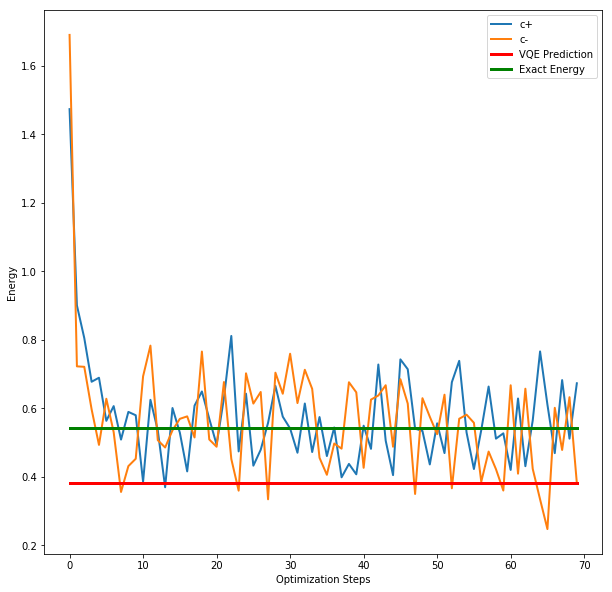

In [6]:
# Use the VQE to find the energy
if backend_name == 'local_qasm_simulator' and optimizer_name == 'SPSA':
    print('(VERY ROUGHLY) SPSA QASM predicted time to completion: {:3.1f} min'.format((2.1e-4)*shots*max_trials/60))
    
if backend_name == 'local_qasm_simulator' and optimizer_name == 'SAN':
    print('SAN QASM predicted time to completion: {:3.1f} min'.format(0.056*max_trials + 1.3)) # 0.056 min / step, 1.3 base min
    
result_vqe = run_algorithm(params,algo_input)
exact_energy = result_exact['energies'][0]
vqe_energy = result_vqe['energy']
print('Exact = {}'.format(exact_energy))
print('VQE = {}'.format(vqe_energy))
print('Percent Error = {:5.2f}%'.format(abs((vqe_energy-exact_energy)/exact_energy)*100))
print('Evaluation Time = {:3.1f} min'.format(result_vqe['eval_time']/60)) 
print('Optimal Parameters: ')
print(list(result_vqe['opt_params']))

# Show convergence. This part can be commented out if you do not want to change the built-in vqe.py file. 
plt.figure(902734,figsize=(10,10))
plt.plot(result_vqe['cplus'],label='c+',linewidth=2)
plt.plot(result_vqe['cminus'],label='c-',linewidth=2)
plt.plot(vqe_energy*np.ones(np.array(result_vqe['cminus']).shape),color='r',label='VQE Prediction',linewidth=3)
plt.plot(exact_energy*np.ones(np.array(result_vqe['cminus']).shape),color='g',label='Exact Energy',linewidth=3)
plt.xlabel('Optimization Steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [7]:
# Now that we have optimized algorithm, time to find prediction for the energy
print('Retrieving algorithm...')
vqealg = get_algorithm_ck(params,algo_input)
print('Getting Stats...')
optimal_energies = []
for t in range(100): # 500 returns a better looking Gaussian, but takes longer.
    optimal_energies.append(vqealg._energy_evaluation(result_vqe['opt_params']))
    if (t+1) % 20 == 0:
        print('{} Events Made'.format(t+1))
    
print('Finished.')

Retrieving algorithm...
Getting Stats...
20 Events Made
40 Events Made
60 Events Made
80 Events Made
100 Events Made
Finished.


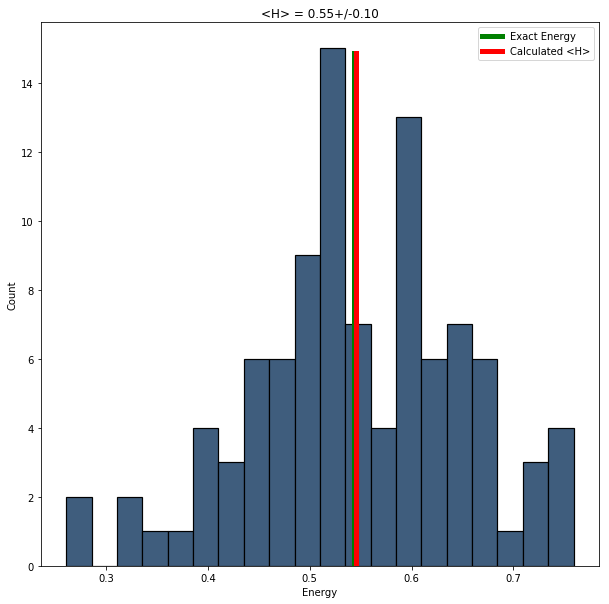

In [8]:
# Plots the histogram showing the spread of the evaluation of <H>
plt.figure(99373665392,figsize=(10,10))
histvals = plt.hist(optimal_energies,20,color="#3F5D7D",edgecolor='black', linewidth=1.2)
plt.title('<H> = {:3.2f}+/-{:3.2f}'.format(np.mean(optimal_energies),np.std(optimal_energies)))
plt.plot([exact_energy for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],color='g',label='Exact Energy',linewidth=5)
plt.plot([np.mean(optimal_energies) for k in range(100)],[max(histvals[0])*k/100 for k in range(100)],color='r',linewidth=5,label='Calculated <H>')
plt.xlabel('Energy')
plt.ylabel('Count')
plt.legend()
plt.show()

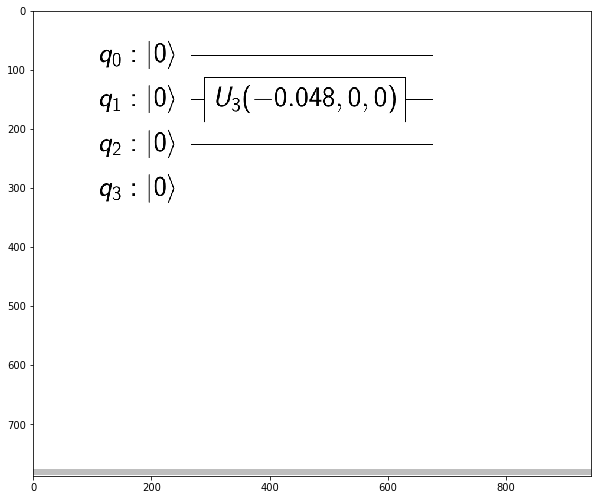

[(0.9997167705831014+0j), 0j, (-0.023798710362004805+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]


In [9]:
# This block returns a graphic of the optimized circuit and the corresponding statevector.
if circuit_name == 'RYSpecialDW':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']
    
    vform = VarFormRYSpecialDW()
    vform.init_args(qubitOp.num_qubits,depth)
    #opt = [2.9,-2.5,-1.2,-1.4,-.64,1.8,.91,3.1,1.2,.11,3.4,-2.9,.85,-1.2,2,3.9,1.6,1.4] # [-1.03950031,0.80118571,1.06668076,0.88260114,0.49424101,-3.06401698,-1.13659464]   
    #opt = [-1.03950031,0.80118571,1.06668076,0.88260114,0.49424101,-3.06401698,-1.13659464]
    #circ = vform.construct_circuit(opt) 
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecial':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecial()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull3':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull3()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialFull2':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialFull2()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))
elif circuit_name == 'RYSpecialQHO':
    if qubitOp.num_qubits == 4:
        ordering = ['0000','1000','0100','1100','0010','1010','0110','1110','0001','1001','0101','1011','0011','1011','0111','1111']
    elif qubitOp.num_qubits == 3:
        ordering = ['000','100','010','110','001','101','011','111']
    elif qubitOp.num_qubits == 5:
        ordering = ['00000','10000','01000','11000','00100','10100','01100','11100','00010','10010','01010','11010','00110','10110','01110','11110',\
                    '00001','10001','01001','11001','00101','10101','01101','11101','00011','10011','01011','11011','00111','10111','01111','11111']

    vform = VarFormRYSpecialQHO()
    vform.init_args(qubitOp.num_qubits,depth)
    circ = vform.construct_circuit(result_vqe['opt_params'])
    c = ClassicalRegister(qubitOp.num_qubits, name='c')
    q = circ.get_qregs()['q']
    e0wf = execute(circ,'local_statevector_simulator',shots=shots).result().get_statevector(circ)
    image = circuitImage(circ)
    plt.figure(1638464859,figsize=(10,10))
    plt.imshow(image)
    plt.show()
    print(list(e0wf))

In [10]:
# get the real parts. Is the actual statevector if you do not use the 2nd and 3rd arguments of u3 in your circuit.
print(list(e0wf.real))

[0.9997167705831014, 0.0, -0.023798710362004805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
# map optimal parameters to [0,2*pi]
optimal = []
for res in result_vqe['opt_params']:
    while res > 2*np.pi or res < 0:
        if res > 2*np.pi:
            res -= 2*np.pi
        elif res < 0:
            res += 2*np.pi
    optimal.append(res)
optimal = np.array(optimal)
print(optimal)

[6.23558339]


In [80]:
# to get a better quality image of the optimized circuit, like the one on the poster, use this function. For me, 
# this opens the image in photoshop.
image.show()

In [14]:
# Code for making the stdev vs shots plot. First, run the anharmonic oscillator (or any other) Hamiltonian on the VQE. 
# Make sure that the resulting trial circuit is well-optimized (i.e., is basically the ground state). Then run this and plot
# the results. I moved the results to Mathematica to do the fit.
optimal_energies = {}
for shots in [200,600,1000,4000,16384]:
    optimal_energies[shots] = []
    print('Making algorithm...')
    params['backend']['shots'] = shots
    vqealg = get_algorithm_ck(params,algo_input)
    print('Getting Stats {}...'.format(shots))
    for t in range(100):
        optimal_energies[shots].append(vqealg._energy_evaluation(result_vqe['opt_params']))
    
print('Finished.')

Making algorithm...
Getting Stats 200...
Making algorithm...
Getting Stats 600...
Making algorithm...
Getting Stats 1000...
Making algorithm...
Getting Stats 4000...
Making algorithm...
Getting Stats 16384...
Finished.


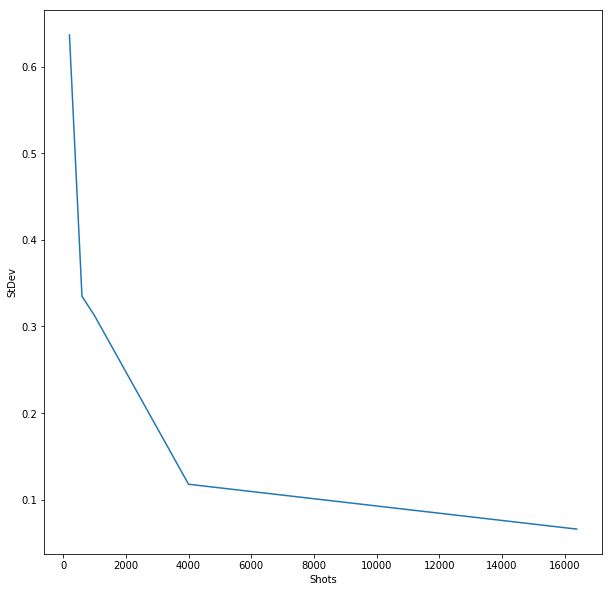

In [16]:
stdevs = [np.std(optimal_energies[ke]) for ke in optimal_energies.keys()]
plt.figure(9299383883883,figsize=(10,10))
plt.plot([200,600,1000,4000,16384],stdevs)
plt.xlabel('Shots')
plt.ylabel('StDev')
plt.show()

In [ ]:
# This code can be used to parse the text file to replace *^ with e (mathematica and Python are different). 
# only needs to be done once
lines = []
f = open('doubled_anharmonic.txt','r')
for line in f:
    lines.append('e'.join(line.split('*^')))
    
f.close()
g = open('doubled_anharmoniccor.txt','w')
g.write(''.join(lines))
g.close()